In [4]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from skimage import io
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
ROOT_DIR = '/kaggle/input/'
in_car_dir = 'hands-dataset-mini/images/'
hagrid_dir = 'hagrid-mini/hagrid/images/'

In [6]:
hagrid_data = pd.read_csv('/kaggle/input/hagrid-mini/hagrid/annotations.csv')
hagrid_data['path'] = hagrid_data['path'].apply(lambda path: hagrid_dir + path)
hagrid_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hagrid-mini/hagrid/images/000b353f-9b45-454e-b...,1053,1276,Hand_empty,155,39,456,473
1,hagrid-mini/hagrid/images/000b9676-731b-4001-a...,788,788,Hand_empty,0,160,124,169
2,hagrid-mini/hagrid/images/000bf8d9-991d-4744-9...,634,788,Hand_empty,450,27,184,254
3,hagrid-mini/hagrid/images/000c55f3-a2c5-4dc0-9...,784,784,Hand_empty,520,165,205,269
4,hagrid-mini/hagrid/images/000de146-3f93-480d-b...,788,788,Hand_empty,528,40,260,298
...,...,...,...,...,...,...,...,...
2995,hagrid-mini/hagrid/images/2ec06634-6370-45ba-a...,777,408,Hand_empty,569,0,164,164
2996,hagrid-mini/hagrid/images/2ec0bc64-38f4-492d-8...,1368,1565,Hand_empty,207,81,267,245
2997,hagrid-mini/hagrid/images/2ecbf1d5-a85c-4751-9...,316,316,Hand_empty,271,28,45,53
2998,hagrid-mini/hagrid/images/2ecca527-c6a7-4f07-8...,863,944,Hand_empty,539,289,169,171


In [7]:
data = pd.read_csv('/kaggle/input/hands-dataset-mini/annotations.csv')
data['path'] = data['path'].apply(lambda path: in_car_dir + path)
data = data.drop(data[data['class'] == 'Hand_food'].index)
data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_unknown,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,321.57,87.79,125.72,157.14
...,...,...,...,...,...,...,...,...
26265,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,195.82,1728.93,349.79,191.07
26266,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,201.43,1723.32,362.89,196.68
26267,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,186.47,1710.22,375.98,209.78
26268,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,1080,1920,Hand_over_wheel,178.99,1706.48,370.37,213.52


In [8]:
data = pd.concat([data, hagrid_data], ignore_index=True)
data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_unknown,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,Hand_empty,321.57,87.79,125.72,157.14
...,...,...,...,...,...,...,...,...
29241,hagrid-mini/hagrid/images/2ec06634-6370-45ba-a...,777,408,Hand_empty,569.00,0.00,164.00,164.00
29242,hagrid-mini/hagrid/images/2ec0bc64-38f4-492d-8...,1368,1565,Hand_empty,207.00,81.00,267.00,245.00
29243,hagrid-mini/hagrid/images/2ecbf1d5-a85c-4751-9...,316,316,Hand_empty,271.00,28.00,45.00,53.00
29244,hagrid-mini/hagrid/images/2ecca527-c6a7-4f07-8...,863,944,Hand_empty,539.00,289.00,169.00,171.00


In [9]:
empty_images_paths = []
images = os.listdir('/kaggle/input/hands-dataset-mini/images')
for image_path in images:
    if in_car_dir + image_path not in data['path'].values:
        empty_images_paths.append(in_car_dir + image_path)

In [10]:
no_hands_data = pd.DataFrame([{'path': path,
                               'frame_width': None,
                               'frame_height': None,
                               'class': 'Not_hand',
                               'X': None,
                               'Y': None,
                               'width': None,
                               'height': None} for path in empty_images_paths])

In [11]:
no_hands_data

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
1,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
2,hands-dataset-mini/images/2d8a53ec-a281-43a4-b...,None,None,Not_hand,None,None,None,None
3,hands-dataset-mini/images/1fde2218-dba6-4aa1-b...,None,None,Not_hand,None,None,None,None
4,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None
...,...,...,...,...,...,...,...,...
25562,hands-dataset-mini/images/1d0e109f-1aa0-45bd-8...,None,None,Not_hand,None,None,None,None
25563,hands-dataset-mini/images/1a6354fd-d0d5-45a3-9...,None,None,Not_hand,None,None,None,None
25564,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None
25565,hands-dataset-mini/images/1e3e3b0d-721f-46b4-9...,None,None,Not_hand,None,None,None,None


In [12]:
data = pd.concat([data, no_hands_data[:10000]], ignore_index=True)

/tmp/ipykernel_34/2201229204.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, no_hands_data[:10000]], ignore_index=True)


In [13]:
data.shape

(39246, 8)

In [14]:
n_classes = len(data['class'].unique())
data['class'].unique()

array(['Hand_unknown', 'Hand_empty', 'Hand_cellular', 'Hand_over_wheel',
       'Hand_under_wheel', 'Not_hand'], dtype=object)

In [15]:
def plot_classes_distribution(data: pd.DataFrame):
    sns.displot(data, x='class')
    plt.xticks(rotation=30)
    plt.show()

In [66]:
torch.manual_seed(54)

## Распределение классов

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


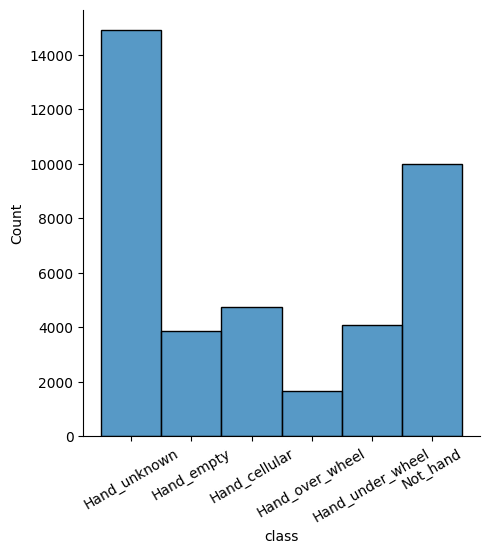

In [17]:
plot_classes_distribution(data)

## Распределение классов на картинках, где бокс не меньше 50 пикселей в длину и ширину

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


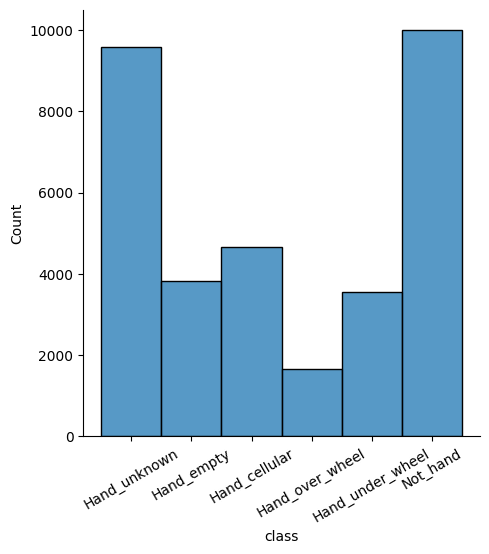

In [18]:
data = data[(data['height'] > 50) & (data['width'] > 50) | (data['class'] == 'Not_hand')]
plot_classes_distribution(data)

In [19]:
le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])

In [20]:
data.head()

,path,frame_width,frame_height,class,X,Y,width,height
0,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,4,115.60,367.98,245.83,111.90
1,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,1,292.86,104.29,130.00,179.28
2,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,1,315.86,88.50,125.00,155.00
3,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,1,319.43,82.79,123.57,165.00
4,hands-dataset-mini/images/00cdf039-5154-494c-b...,640,510,1,321.57,87.79,125.72,157.14


In [21]:
data.shape

(33284, 8)

In [22]:
data_copy = data.copy()

In [23]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(data['class'].values),
                                     y = data['class'].values)

In [24]:
class_weights = dict(zip(np.unique(data['class'].values), class_weights))

In [25]:
np.unique(data['class'].values)

array([0, 1, 2, 3, 4, 5])

In [26]:
le.inverse_transform(np.unique(data['class'].values))

array(['Hand_cellular', 'Hand_empty', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_unknown', 'Not_hand'], dtype=object)

In [27]:
class_weights

{0: 1.1909260054386719,
 1: 1.4510419391402911,
 2: 3.347817340575337,
 3: 1.5569276826644214,
 4: 0.5788723086020383,
 5: 0.5547333333333333}

In [28]:
def get_random_crop(image):
    frame_width, frame_height = image.size
        
    crop_height = random.randint(120, 200)
    crop_width = random.randint(120, 200)

    x = random.randint(0, frame_width - crop_width)
    y = random.randint(0, frame_height - crop_height)

    crop_area = (x, y, x + crop_width, y + crop_height)
    return image.crop(crop_area)

## Создание датасета

In [29]:
class DriverHandsDataset(Dataset):
    def __init__(self, annotations: pd.DataFrame, root_dir, transform=None):
        self.annotations = annotations
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # image = io.imread(img_path)
        image = Image.open(img_path)
        
        y_label = torch.tensor(int(self.annotations.iloc[index]['class']))
        
        if le.inverse_transform([y_label.item()])[0] == 'Not_hand':
            image = get_random_crop(image)
            
        else:
            x, y, width, height, frame_width, frame_height = (self.annotations.iloc[index]['X'], 
                                   self.annotations.iloc[index]['Y'],
                                   self.annotations.iloc[index]['width'],
                                   self.annotations.iloc[index]['height'],
                                   self.annotations.iloc[index]['frame_width'],
                                   self.annotations.iloc[index]['frame_height'])

            crop_area = (max(0, x - random.randint(10, 30)),
                         max(0, y - random.randint(10, 30)),
                         min(x + width + random.randint(10, 30), frame_width),
                         min(y + height + random.randint(10, 30), frame_height))
            image = image.crop(crop_area)
        
        if self.transform:
            image = self.transform(image)
            
        return image, y_label

In [30]:
dataset = DriverHandsDataset(data, ROOT_DIR)

In [31]:
dataset[30000]

(<PIL.Image.Image image mode=RGB size=183x120>, tensor(5))

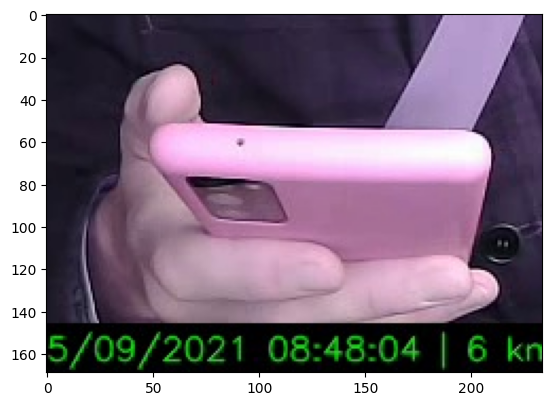

In [33]:
random_index = random.randint(0, len(dataset) - 1) 
  
# Plotting the randomly selected image 
plt.imshow(dataset[random_index][0])
plt.show()

In [32]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [33]:
dataset = DriverHandsDataset(data, ROOT_DIR, transform=transform)

In [34]:
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [0.7, 0.3], generator)

In [35]:
device = 'cuda'

In [36]:
batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

# Обучение DenseNet121

In [37]:
densenet = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
densenet.classifier = nn.Linear(in_features=1024, out_features=n_classes, bias=True)

# for param in densenet.parameters():
#     param.requires_grad = False
    
# for param in densenet.classifier.parameters():
#     param.requires_grad = True
# densenet.load_state_dict(torch.load('/kaggle/working/densenet_mini_data.pt'))
densenet.load_state_dict(torch.load('/kaggle/working/densenet_mini_data_with_hagrid.pt'))
densenet = densenet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 61.3MB/s]


In [46]:
torch.Tensor(list(class_weights.values()))

tensor([1.1909, 1.4510, 3.3478, 1.5569, 0.5789, 0.5547])

In [47]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(densenet.parameters(), lr=0.001, momentum=0.9)

In [37]:
def train(model, criterion, optimizer, n_epochs=2):
    model.train()
    
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [51]:
train(densenet, criterion, optimizer)

  3%|▎         | 20/729 [00:18<10:16,  1.15it/s]

[1,    20] loss: 1.559


  5%|▌         | 40/729 [00:35<08:59,  1.28it/s]

[1,    40] loss: 0.812


  8%|▊         | 60/729 [00:53<09:47,  1.14it/s]

[1,    60] loss: 0.576


 11%|█         | 80/729 [01:10<09:02,  1.20it/s]

[1,    80] loss: 0.401


 14%|█▎        | 100/729 [01:27<08:40,  1.21it/s]

[1,   100] loss: 0.399


 16%|█▋        | 120/729 [01:44<08:21,  1.21it/s]

[1,   120] loss: 0.283


 19%|█▉        | 140/729 [02:00<07:58,  1.23it/s]

[1,   140] loss: 0.302


 22%|██▏       | 160/729 [02:16<08:02,  1.18it/s]

[1,   160] loss: 0.284


 25%|██▍       | 180/729 [02:33<07:34,  1.21it/s]

[1,   180] loss: 0.285


 27%|██▋       | 200/729 [02:48<07:00,  1.26it/s]

[1,   200] loss: 0.191


 30%|███       | 220/729 [03:05<06:59,  1.21it/s]

[1,   220] loss: 0.189


 33%|███▎      | 240/729 [03:22<06:50,  1.19it/s]

[1,   240] loss: 0.256


 36%|███▌      | 260/729 [03:38<06:11,  1.26it/s]

[1,   260] loss: 0.164


 38%|███▊      | 280/729 [03:55<06:24,  1.17it/s]

[1,   280] loss: 0.204


 41%|████      | 300/729 [04:11<05:58,  1.20it/s]

[1,   300] loss: 0.152


 44%|████▍     | 320/729 [04:27<05:26,  1.25it/s]

[1,   320] loss: 0.181


 47%|████▋     | 340/729 [04:43<05:16,  1.23it/s]

[1,   340] loss: 0.186


 49%|████▉     | 360/729 [05:00<05:13,  1.18it/s]

[1,   360] loss: 0.140


 52%|█████▏    | 380/729 [05:17<04:42,  1.23it/s]

[1,   380] loss: 0.192


 55%|█████▍    | 400/729 [05:33<04:33,  1.20it/s]

[1,   400] loss: 0.134


 58%|█████▊    | 420/729 [05:49<04:19,  1.19it/s]

[1,   420] loss: 0.113


 60%|██████    | 440/729 [06:05<03:55,  1.23it/s]

[1,   440] loss: 0.164


 63%|██████▎   | 460/729 [06:21<03:31,  1.27it/s]

[1,   460] loss: 0.167


 66%|██████▌   | 480/729 [06:37<03:23,  1.22it/s]

[1,   480] loss: 0.186


 69%|██████▊   | 500/729 [06:53<02:55,  1.30it/s]

[1,   500] loss: 0.153


 71%|███████▏  | 520/729 [07:09<02:48,  1.24it/s]

[1,   520] loss: 0.139


 74%|███████▍  | 540/729 [07:24<02:23,  1.32it/s]

[1,   540] loss: 0.129


 77%|███████▋  | 560/729 [07:40<02:20,  1.20it/s]

[1,   560] loss: 0.150


 80%|███████▉  | 580/729 [07:56<01:53,  1.31it/s]

[1,   580] loss: 0.132


 82%|████████▏ | 600/729 [08:12<01:48,  1.19it/s]

[1,   600] loss: 0.126


 85%|████████▌ | 620/729 [08:28<01:30,  1.20it/s]

[1,   620] loss: 0.113


 88%|████████▊ | 640/729 [08:45<01:13,  1.20it/s]

[1,   640] loss: 0.110


 91%|█████████ | 660/729 [09:01<00:52,  1.31it/s]

[1,   660] loss: 0.106


 93%|█████████▎| 680/729 [09:17<00:40,  1.22it/s]

[1,   680] loss: 0.104


 96%|█████████▌| 700/729 [09:33<00:22,  1.32it/s]

[1,   700] loss: 0.126


 99%|█████████▉| 720/729 [09:49<00:07,  1.27it/s]

[1,   720] loss: 0.102


  3%|▎         | 20/729 [00:11<06:37,  1.78it/s]

[2,    20] loss: 0.097


  5%|▌         | 40/729 [00:23<07:47,  1.47it/s]

[2,    40] loss: 0.065


  8%|▊         | 60/729 [00:35<06:19,  1.77it/s]

[2,    60] loss: 0.088


 11%|█         | 80/729 [00:48<06:29,  1.67it/s]

[2,    80] loss: 0.069


 14%|█▎        | 100/729 [01:01<06:57,  1.51it/s]

[2,   100] loss: 0.081


 16%|█▋        | 120/729 [01:13<05:49,  1.74it/s]

[2,   120] loss: 0.085


 19%|█▉        | 140/729 [01:25<06:25,  1.53it/s]

[2,   140] loss: 0.057


 22%|██▏       | 160/729 [01:38<05:57,  1.59it/s]

[2,   160] loss: 0.094


 25%|██▍       | 180/729 [01:49<05:15,  1.74it/s]

[2,   180] loss: 0.070


 27%|██▋       | 200/729 [02:02<05:50,  1.51it/s]

[2,   200] loss: 0.076


 30%|███       | 220/729 [02:14<05:07,  1.66it/s]

[2,   220] loss: 0.113


 33%|███▎      | 240/729 [02:26<04:49,  1.69it/s]

[2,   240] loss: 0.097


 36%|███▌      | 260/729 [02:39<05:01,  1.56it/s]

[2,   260] loss: 0.080


 38%|███▊      | 280/729 [02:51<04:11,  1.79it/s]

[2,   280] loss: 0.099


 41%|████      | 300/729 [03:02<04:23,  1.63it/s]

[2,   300] loss: 0.077


 44%|████▍     | 320/729 [03:15<04:03,  1.68it/s]

[2,   320] loss: 0.068


 47%|████▋     | 340/729 [03:27<03:53,  1.67it/s]

[2,   340] loss: 0.069


 49%|████▉     | 360/729 [03:40<04:07,  1.49it/s]

[2,   360] loss: 0.070


 52%|█████▏    | 380/729 [03:52<03:25,  1.70it/s]

[2,   380] loss: 0.106


 55%|█████▍    | 400/729 [04:04<03:31,  1.55it/s]

[2,   400] loss: 0.079


 58%|█████▊    | 420/729 [04:16<03:23,  1.52it/s]

[2,   420] loss: 0.061


 60%|██████    | 440/729 [04:28<02:41,  1.79it/s]

[2,   440] loss: 0.079


 63%|██████▎   | 460/729 [04:40<02:33,  1.75it/s]

[2,   460] loss: 0.068


 66%|██████▌   | 480/729 [04:52<02:27,  1.69it/s]

[2,   480] loss: 0.064


 69%|██████▊   | 500/729 [05:04<02:17,  1.67it/s]

[2,   500] loss: 0.045


 71%|███████▏  | 520/729 [05:15<01:59,  1.75it/s]

[2,   520] loss: 0.087


 74%|███████▍  | 540/729 [05:27<01:47,  1.75it/s]

[2,   540] loss: 0.093


 77%|███████▋  | 560/729 [05:40<01:44,  1.62it/s]

[2,   560] loss: 0.066


 80%|███████▉  | 580/729 [05:51<01:27,  1.71it/s]

[2,   580] loss: 0.069


 82%|████████▏ | 600/729 [06:03<01:18,  1.65it/s]

[2,   600] loss: 0.088


 85%|████████▌ | 620/729 [06:15<01:02,  1.76it/s]

[2,   620] loss: 0.064


 88%|████████▊ | 640/729 [06:26<00:50,  1.78it/s]

[2,   640] loss: 0.047


 91%|█████████ | 660/729 [06:38<00:38,  1.80it/s]

[2,   660] loss: 0.066


 93%|█████████▎| 680/729 [06:49<00:28,  1.74it/s]

[2,   680] loss: 0.075


 96%|█████████▌| 700/729 [07:01<00:16,  1.77it/s]

[2,   700] loss: 0.078


 99%|█████████▉| 720/729 [07:12<00:05,  1.79it/s]

[2,   720] loss: 0.098


100%|██████████| 729/729 [07:17<00:00,  1.67it/s]

Finished Training


In [208]:
torch.save(densenet.state_dict(), '/kaggle/working/densenet_mini_data_with_hagrid.pt')

In [39]:
# torch.save(densenet.state_dict(), '/kaggle/working/densenet_mini_data.pt')

In [52]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
all_labels = np.array([])
all_preds = np.array([])
densenet.eval()
for data in tqdm(testloader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    # calculate outputs by running images through the network
#         print(images.shape)
    outputs = F.softmax(densenet(images), dim=-1)
#         print(densenet(images).shape)
    # the class with the highest energy is what we choose as prediction
#         print(outputs.data)
#         break
    _, predicted = torch.max(outputs.data, dim=-1)
#         print(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    all_labels = np.append(all_labels, labels.cpu().numpy())
    all_preds = np.append(all_preds, predicted.cpu().numpy())

100%|██████████| 313/313 [03:39<00:00,  1.42it/s]


In [53]:
all_preds = all_preds.astype(int)
all_labels = all_labels.astype(int)

In [54]:
unique, counts = np.unique(all_preds, return_counts=True)
dict(zip(unique, counts))

{0: 1430, 1: 1211, 2: 585, 3: 1083, 4: 2657, 5: 3019}

## Подсчет метрик отдельно по классам

In [55]:
target_names = le.inverse_transform(range(0, n_classes))
print(classification_report(all_labels, all_preds, target_names=target_names))

                  precision    recall  f1-score   support

   Hand_cellular       0.98      0.99      0.98      1405
      Hand_empty       0.95      0.98      0.97      1173
 Hand_over_wheel       0.83      0.99      0.90       490
Hand_under_wheel       0.96      0.99      0.98      1055
    Hand_unknown       0.99      0.93      0.96      2840
        Not_hand       1.00      1.00      1.00      3022

        accuracy                           0.97      9985
       macro avg       0.95      0.98      0.96      9985
    weighted avg       0.97      0.97      0.97      9985



In [56]:
target_names

array(['Hand_cellular', 'Hand_empty', 'Hand_over_wheel',
       'Hand_under_wheel', 'Hand_unknown', 'Not_hand'], dtype=object)

<Figure size 2000x400 with 0 Axes>

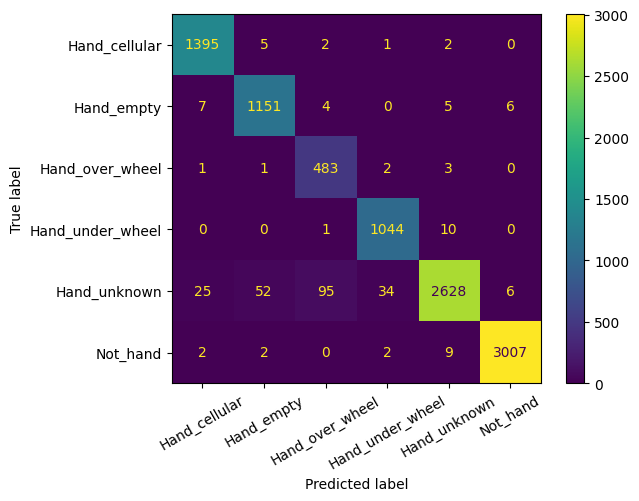

In [57]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
disp.plot()
plt.xticks(rotation=30)
plt.show()

In [193]:
def predict_one_random_image(net, data):
    net.eval()
    dataset_no_transform = DriverHandsDataset(data, ROOT_DIR)
    random_index = random.randint(0, len(dataset_no_transform) - 1) 
  
    plt.imshow(dataset_no_transform[random_index][0])
    true_label = le.inverse_transform([dataset_no_transform[random_index][1].item()])[0]
    
    inp_image = torch.unsqueeze(transform(dataset_no_transform[random_index][0]), dim=0)

    probs = F.softmax(net.cpu()(inp_image), dim=-1)
    
    _, predicted = torch.max(probs.data, dim=-1)
    pred_label = le.inverse_transform([predicted.item()])[0]
    
    plt.title(f'gt: {true_label}, pred: {pred_label}')
    
    plt.show()

In [127]:
# torch.cuda.empty_cache()

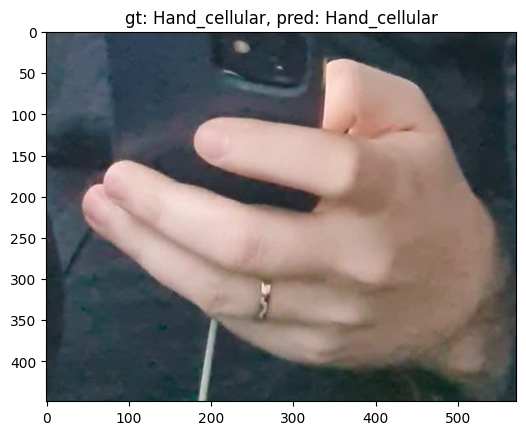

In [201]:
predict_one_random_image(densenet, data_copy)

## Проверка предсказаний модели на кадрах, где нет рук

In [202]:
len(empty_images_paths)

25544

In [203]:
class NoHandsDataset(Dataset):
    def __init__(self, paths: list, root_dir, transform=None):
        self.paths = paths
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.paths[index])
        # image = io.imread(img_path)
        image = Image.open(img_path)
        frame_width, frame_height = image.size
        
        crop_height = random.randint(120, 200)
        crop_width = random.randint(120, 200)
        
        x = random.randint(0, frame_width - crop_width)
        y = random.randint(0, frame_height - crop_height)
        
        crop_area = (x, y, x + crop_width, y + crop_height)
        image = image.crop(crop_area)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [204]:
no_hands_dataset_no_transform = NoHandsDataset(empty_images_paths[:5000], ROOT_DIR)

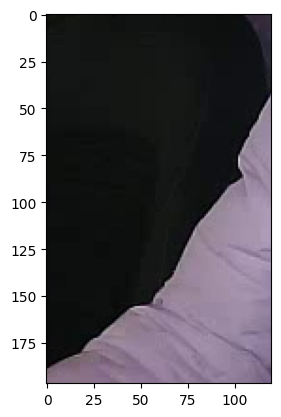

In [205]:
random_index = random.randint(0, len(no_hands_dataset_no_transform) - 1) 
  
# Plotting the randomly selected image 
plt.imshow(no_hands_dataset_no_transform[random_index])
plt.show()

In [206]:
no_hands_dataset = NoHandsDataset(empty_images_paths, ROOT_DIR, transform=transform)

In [207]:
no_hands_loader = DataLoader(no_hands_dataset, batch_size=32,
                                          shuffle=True)

In [46]:
no_hands_preds = np.array([])
densenet = densenet.to(device)
densenet.eval()
for data in tqdm(no_hands_loader):
    images = data
    images = images.to(device)
    # calculate outputs by running images through the network
#         print(images.shape)
    outputs = F.softmax(densenet(images), dim=-1)
#         print(densenet(images).shape)
    # the class with the highest energy is what we choose as prediction
#         print(outputs.data)
#         break
    _, predicted = torch.max(outputs.data, dim=-1)
#         print(predicted.cpu().numpy())

    no_hands_preds = np.append(no_hands_preds, predicted.cpu().numpy())

100%|██████████| 799/799 [09:05<00:00,  1.47it/s]


In [47]:
len(no_hands_preds)

25544

In [48]:
unique, counts = np.unique(no_hands_preds, return_counts=True)

In [49]:
unique = le.inverse_transform(unique.astype(int))

### Количество предсказаний по классам на кадрах без рук

In [50]:
dict(zip(unique, counts))

{'Hand_cellular': 3,
 'Hand_empty': 35,
 'Hand_food': 28,
 'Hand_over_wheel': 3,
 'Hand_unknown': 55,
 'Not_hand': 25420}

# Обучение MobileNetV2

In [38]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 62.1MB/s]


In [39]:
mobilenet.classifier[1] = nn.Linear(1280, n_classes, bias=True)
mobilenet = mobilenet.to(device)

In [40]:
mobilenet.load_state_dict(torch.load('/kaggle/working/mobilenet_mini_data_with_hagrid.pt'))

<All keys matched successfully>

In [41]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(mobilenet.parameters(), lr=0.001, momentum=0.9)

In [39]:
train(mobilenet, criterion, optimizer)

  3%|▎         | 20/729 [00:19<11:22,  1.04it/s]

[1,    20] loss: 1.534


  5%|▌         | 40/729 [00:39<11:22,  1.01it/s]

[1,    40] loss: 0.718


  8%|▊         | 60/729 [00:58<10:04,  1.11it/s]

[1,    60] loss: 0.559


 11%|█         | 80/729 [01:18<10:05,  1.07it/s]

[1,    80] loss: 0.415


 14%|█▎        | 100/729 [01:37<10:46,  1.03s/it]

[1,   100] loss: 0.321


 16%|█▋        | 120/729 [01:56<09:31,  1.06it/s]

[1,   120] loss: 0.400


 19%|█▉        | 140/729 [02:14<08:50,  1.11it/s]

[1,   140] loss: 0.274


 22%|██▏       | 160/729 [02:33<08:37,  1.10it/s]

[1,   160] loss: 0.233


 25%|██▍       | 180/729 [02:51<08:40,  1.05it/s]

[1,   180] loss: 0.250


 27%|██▋       | 200/729 [03:10<08:11,  1.08it/s]

[1,   200] loss: 0.244


 30%|███       | 220/729 [03:27<07:32,  1.12it/s]

[1,   220] loss: 0.226


 33%|███▎      | 240/729 [03:46<07:39,  1.06it/s]

[1,   240] loss: 0.240


 36%|███▌      | 260/729 [04:04<07:15,  1.08it/s]

[1,   260] loss: 0.165


 38%|███▊      | 280/729 [04:21<06:30,  1.15it/s]

[1,   280] loss: 0.187


 41%|████      | 300/729 [04:39<06:28,  1.10it/s]

[1,   300] loss: 0.197


 44%|████▍     | 320/729 [04:57<06:02,  1.13it/s]

[1,   320] loss: 0.222


 47%|████▋     | 340/729 [05:15<06:01,  1.08it/s]

[1,   340] loss: 0.214


 49%|████▉     | 360/729 [05:33<05:42,  1.08it/s]

[1,   360] loss: 0.135


 52%|█████▏    | 380/729 [05:52<05:12,  1.12it/s]

[1,   380] loss: 0.168


 55%|█████▍    | 400/729 [06:10<04:46,  1.15it/s]

[1,   400] loss: 0.199


 58%|█████▊    | 420/729 [06:28<04:35,  1.12it/s]

[1,   420] loss: 0.184


 60%|██████    | 440/729 [06:46<04:24,  1.09it/s]

[1,   440] loss: 0.181


 63%|██████▎   | 460/729 [07:03<03:58,  1.13it/s]

[1,   460] loss: 0.162


 66%|██████▌   | 480/729 [07:21<03:37,  1.15it/s]

[1,   480] loss: 0.152


 69%|██████▊   | 500/729 [07:38<03:24,  1.12it/s]

[1,   500] loss: 0.169


 71%|███████▏  | 520/729 [07:56<02:58,  1.17it/s]

[1,   520] loss: 0.174


 74%|███████▍  | 540/729 [08:13<02:43,  1.16it/s]

[1,   540] loss: 0.100


 77%|███████▋  | 560/729 [08:30<02:26,  1.16it/s]

[1,   560] loss: 0.138


 80%|███████▉  | 580/729 [08:48<02:17,  1.08it/s]

[1,   580] loss: 0.140


 82%|████████▏ | 600/729 [09:06<01:51,  1.16it/s]

[1,   600] loss: 0.132


 85%|████████▌ | 620/729 [09:26<02:39,  1.47s/it]

[1,   620] loss: 0.138


 88%|████████▊ | 640/729 [09:46<01:24,  1.06it/s]

[1,   640] loss: 0.162


 91%|█████████ | 660/729 [10:05<01:07,  1.03it/s]

[1,   660] loss: 0.118


 93%|█████████▎| 680/729 [10:25<00:49,  1.00s/it]

[1,   680] loss: 0.115


 96%|█████████▌| 700/729 [10:45<00:28,  1.00it/s]

[1,   700] loss: 0.112


 99%|█████████▉| 720/729 [11:05<00:09,  1.01s/it]

[1,   720] loss: 0.099


  3%|▎         | 20/729 [00:11<07:23,  1.60it/s]

[2,    20] loss: 0.100


  5%|▌         | 40/729 [00:23<08:09,  1.41it/s]

[2,    40] loss: 0.092


  8%|▊         | 60/729 [00:36<06:48,  1.64it/s]

[2,    60] loss: 0.154


 11%|█         | 80/729 [00:48<06:09,  1.76it/s]

[2,    80] loss: 0.089


 14%|█▎        | 100/729 [00:59<05:35,  1.88it/s]

[2,   100] loss: 0.100


 16%|█▋        | 120/729 [01:11<06:01,  1.69it/s]

[2,   120] loss: 0.088


 19%|█▉        | 140/729 [01:23<06:11,  1.58it/s]

[2,   140] loss: 0.106


 22%|██▏       | 160/729 [01:35<05:36,  1.69it/s]

[2,   160] loss: 0.128


 25%|██▍       | 180/729 [01:47<04:52,  1.88it/s]

[2,   180] loss: 0.087


 27%|██▋       | 200/729 [01:58<04:39,  1.89it/s]

[2,   200] loss: 0.063


 30%|███       | 220/729 [02:10<04:39,  1.82it/s]

[2,   220] loss: 0.103


 33%|███▎      | 240/729 [02:22<05:18,  1.53it/s]

[2,   240] loss: 0.091


 36%|███▌      | 260/729 [02:34<04:53,  1.60it/s]

[2,   260] loss: 0.092


 38%|███▊      | 280/729 [02:46<04:18,  1.74it/s]

[2,   280] loss: 0.092


 41%|████      | 300/729 [02:58<03:49,  1.87it/s]

[2,   300] loss: 0.106


 44%|████▍     | 320/729 [03:10<04:46,  1.43it/s]

[2,   320] loss: 0.079


 47%|████▋     | 340/729 [03:24<04:53,  1.33it/s]

[2,   340] loss: 0.063


 49%|████▉     | 360/729 [03:35<03:53,  1.58it/s]

[2,   360] loss: 0.093


 52%|█████▏    | 380/729 [03:47<03:23,  1.72it/s]

[2,   380] loss: 0.078


 55%|█████▍    | 400/729 [03:59<02:58,  1.84it/s]

[2,   400] loss: 0.109


 58%|█████▊    | 420/729 [04:10<02:45,  1.87it/s]

[2,   420] loss: 0.104


 60%|██████    | 440/729 [04:22<02:54,  1.66it/s]

[2,   440] loss: 0.124


 63%|██████▎   | 460/729 [04:34<02:26,  1.83it/s]

[2,   460] loss: 0.104


 66%|██████▌   | 480/729 [04:45<02:27,  1.69it/s]

[2,   480] loss: 0.090


 69%|██████▊   | 500/729 [04:57<02:04,  1.85it/s]

[2,   500] loss: 0.074


 71%|███████▏  | 520/729 [05:08<01:56,  1.79it/s]

[2,   520] loss: 0.122


 74%|███████▍  | 540/729 [05:21<01:56,  1.63it/s]

[2,   540] loss: 0.091


 77%|███████▋  | 560/729 [05:33<01:38,  1.72it/s]

[2,   560] loss: 0.077


 80%|███████▉  | 580/729 [05:44<01:25,  1.75it/s]

[2,   580] loss: 0.080


 82%|████████▏ | 600/729 [05:56<01:08,  1.89it/s]

[2,   600] loss: 0.077


 85%|████████▌ | 620/729 [06:07<01:00,  1.81it/s]

[2,   620] loss: 0.074


 88%|████████▊ | 640/729 [06:19<00:51,  1.72it/s]

[2,   640] loss: 0.083


 91%|█████████ | 660/729 [06:30<00:39,  1.74it/s]

[2,   660] loss: 0.065


 93%|█████████▎| 680/729 [06:42<00:29,  1.67it/s]

[2,   680] loss: 0.102


 96%|█████████▌| 700/729 [06:53<00:16,  1.72it/s]

[2,   700] loss: 0.101


 99%|█████████▉| 720/729 [07:04<00:05,  1.74it/s]

[2,   720] loss: 0.102


100%|██████████| 729/729 [07:08<00:00,  1.70it/s]

Finished Training


In [40]:
torch.save(mobilenet.state_dict(), '/kaggle/working/mobilenet_mini_data_with_hagrid.pt')

# Обучение DenseNet201

In [42]:
densenet201 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
densenet201.classifier = nn.Linear(in_features=1920, out_features=n_classes, bias=True)
densenet201.load_state_dict(torch.load('/kaggle/working/densenet201_mini_data_with_hagrid.pt'))
densenet201 = densenet201.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:05<00:00, 15.2MB/s]


In [41]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(list(class_weights.values())).to(device))
optimizer = optim.SGD(densenet201.parameters(), lr=0.001, momentum=0.9)

In [42]:
train(densenet201, criterion, optimizer)

  3%|▎         | 20/729 [00:22<11:59,  1.01s/it]

[1,    20] loss: 1.501


  5%|▌         | 40/729 [00:44<12:42,  1.11s/it]

[1,    40] loss: 0.786


  8%|▊         | 60/729 [01:05<12:18,  1.10s/it]

[1,    60] loss: 0.499


 11%|█         | 80/729 [01:26<11:24,  1.06s/it]

[1,    80] loss: 0.395


 14%|█▎        | 100/729 [01:47<11:06,  1.06s/it]

[1,   100] loss: 0.339


 16%|█▋        | 120/729 [02:09<11:08,  1.10s/it]

[1,   120] loss: 0.293


 19%|█▉        | 140/729 [02:30<10:41,  1.09s/it]

[1,   140] loss: 0.283


 22%|██▏       | 160/729 [02:52<10:17,  1.09s/it]

[1,   160] loss: 0.271


 25%|██▍       | 180/729 [03:13<09:46,  1.07s/it]

[1,   180] loss: 0.256


 27%|██▋       | 200/729 [03:35<09:55,  1.13s/it]

[1,   200] loss: 0.200


 30%|███       | 220/729 [03:56<08:58,  1.06s/it]

[1,   220] loss: 0.192


 33%|███▎      | 240/729 [04:17<08:25,  1.03s/it]

[1,   240] loss: 0.190


 36%|███▌      | 260/729 [04:38<08:08,  1.04s/it]

[1,   260] loss: 0.203


 38%|███▊      | 280/729 [05:00<08:20,  1.11s/it]

[1,   280] loss: 0.126


 41%|████      | 300/729 [05:21<07:24,  1.04s/it]

[1,   300] loss: 0.161


 44%|████▍     | 320/729 [05:42<07:09,  1.05s/it]

[1,   320] loss: 0.148


 47%|████▋     | 340/729 [06:04<06:57,  1.07s/it]

[1,   340] loss: 0.129


 49%|████▉     | 360/729 [06:25<06:15,  1.02s/it]

[1,   360] loss: 0.112


 52%|█████▏    | 380/729 [06:46<06:34,  1.13s/it]

[1,   380] loss: 0.092


 55%|█████▍    | 400/729 [07:07<05:39,  1.03s/it]

[1,   400] loss: 0.155


 58%|█████▊    | 420/729 [07:28<05:17,  1.03s/it]

[1,   420] loss: 0.170


 60%|██████    | 440/729 [07:49<05:11,  1.08s/it]

[1,   440] loss: 0.132


 63%|██████▎   | 460/729 [08:11<04:46,  1.07s/it]

[1,   460] loss: 0.113


 66%|██████▌   | 480/729 [08:32<04:26,  1.07s/it]

[1,   480] loss: 0.138


 69%|██████▊   | 500/729 [08:54<04:19,  1.13s/it]

[1,   500] loss: 0.143


 71%|███████▏  | 520/729 [09:15<03:45,  1.08s/it]

[1,   520] loss: 0.127


 74%|███████▍  | 540/729 [09:37<03:37,  1.15s/it]

[1,   540] loss: 0.144


 77%|███████▋  | 560/729 [10:00<03:22,  1.20s/it]

[1,   560] loss: 0.132


 80%|███████▉  | 580/729 [10:21<02:39,  1.07s/it]

[1,   580] loss: 0.130


 82%|████████▏ | 600/729 [10:42<02:13,  1.04s/it]

[1,   600] loss: 0.114


 85%|████████▌ | 620/729 [11:03<01:51,  1.02s/it]

[1,   620] loss: 0.145


 88%|████████▊ | 640/729 [11:24<01:36,  1.08s/it]

[1,   640] loss: 0.077


 91%|█████████ | 660/729 [11:45<01:13,  1.06s/it]

[1,   660] loss: 0.110


 93%|█████████▎| 680/729 [12:06<00:50,  1.02s/it]

[1,   680] loss: 0.139


 96%|█████████▌| 700/729 [12:27<00:31,  1.07s/it]

[1,   700] loss: 0.117


 99%|█████████▉| 720/729 [12:49<00:09,  1.06s/it]

[1,   720] loss: 0.113


  3%|▎         | 20/729 [00:14<08:35,  1.38it/s]

[2,    20] loss: 0.070


  5%|▌         | 40/729 [00:27<07:44,  1.48it/s]

[2,    40] loss: 0.071


  8%|▊         | 60/729 [00:42<07:55,  1.41it/s]

[2,    60] loss: 0.062


 11%|█         | 80/729 [00:56<07:33,  1.43it/s]

[2,    80] loss: 0.083


 14%|█▎        | 100/729 [01:10<07:28,  1.40it/s]

[2,   100] loss: 0.045


 16%|█▋        | 120/729 [01:24<07:16,  1.39it/s]

[2,   120] loss: 0.072


 19%|█▉        | 140/729 [01:38<07:24,  1.33it/s]

[2,   140] loss: 0.052


 22%|██▏       | 160/729 [01:52<06:37,  1.43it/s]

[2,   160] loss: 0.091


 25%|██▍       | 180/729 [02:06<06:33,  1.40it/s]

[2,   180] loss: 0.095


 27%|██▋       | 200/729 [02:20<05:57,  1.48it/s]

[2,   200] loss: 0.075


 30%|███       | 220/729 [02:34<06:02,  1.40it/s]

[2,   220] loss: 0.050


 33%|███▎      | 240/729 [02:49<05:51,  1.39it/s]

[2,   240] loss: 0.035


 36%|███▌      | 260/729 [03:03<05:39,  1.38it/s]

[2,   260] loss: 0.064


 38%|███▊      | 280/729 [03:17<05:20,  1.40it/s]

[2,   280] loss: 0.055


 41%|████      | 300/729 [03:32<04:55,  1.45it/s]

[2,   300] loss: 0.084


 44%|████▍     | 320/729 [03:46<04:55,  1.39it/s]

[2,   320] loss: 0.073


 47%|████▋     | 340/729 [04:00<04:37,  1.40it/s]

[2,   340] loss: 0.079


 49%|████▉     | 360/729 [04:15<04:40,  1.32it/s]

[2,   360] loss: 0.048


 52%|█████▏    | 380/729 [04:29<04:05,  1.42it/s]

[2,   380] loss: 0.094


 55%|█████▍    | 400/729 [04:43<03:52,  1.41it/s]

[2,   400] loss: 0.072


 58%|█████▊    | 420/729 [04:57<03:40,  1.40it/s]

[2,   420] loss: 0.074


 60%|██████    | 440/729 [05:12<03:20,  1.44it/s]

[2,   440] loss: 0.088


 63%|██████▎   | 460/729 [05:26<03:15,  1.38it/s]

[2,   460] loss: 0.071


 66%|██████▌   | 480/729 [05:41<02:54,  1.43it/s]

[2,   480] loss: 0.067


 69%|██████▊   | 500/729 [05:55<02:41,  1.42it/s]

[2,   500] loss: 0.051


 71%|███████▏  | 520/729 [06:09<02:23,  1.45it/s]

[2,   520] loss: 0.094


 74%|███████▍  | 540/729 [06:23<02:10,  1.44it/s]

[2,   540] loss: 0.055


 77%|███████▋  | 560/729 [06:38<01:59,  1.42it/s]

[2,   560] loss: 0.075


 80%|███████▉  | 580/729 [06:52<01:49,  1.36it/s]

[2,   580] loss: 0.052


 82%|████████▏ | 600/729 [07:07<01:32,  1.40it/s]

[2,   600] loss: 0.050


 85%|████████▌ | 620/729 [07:21<01:17,  1.41it/s]

[2,   620] loss: 0.052


 88%|████████▊ | 640/729 [07:36<01:06,  1.34it/s]

[2,   640] loss: 0.053


 91%|█████████ | 660/729 [07:50<00:48,  1.42it/s]

[2,   660] loss: 0.055


 93%|█████████▎| 680/729 [08:05<00:36,  1.36it/s]

[2,   680] loss: 0.060


 96%|█████████▌| 700/729 [08:19<00:20,  1.40it/s]

[2,   700] loss: 0.047


 99%|█████████▉| 720/729 [08:33<00:06,  1.37it/s]

[2,   720] loss: 0.058


100%|██████████| 729/729 [08:39<00:00,  1.40it/s]

Finished Training


In [56]:
torch.save(densenet201.state_dict(), '/kaggle/working/densenet201_mini_data_with_hagrid.pt')

# Подсчет метрик моделей на тестовой выборке и их сравнение

In [43]:
def test_inference(model):
    '''Returns labels, predictions and probabilities of classes for each sample'''
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    all_labels = np.array([])
    all_preds = np.array([])
    all_proba = np.array([])
    model.eval()
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = F.softmax(model(images), dim=-1)
    #         print(densenet(images).shape)
        # the class with the highest energy is what we choose as prediction
    #         print(outputs.data)
    #         break
        _, predicted = torch.max(outputs.data, dim=-1)
    #         print(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels = np.append(all_labels, labels.cpu().numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        all_proba = np.append(all_proba, outputs.detach().cpu().numpy())
        
    return all_labels, all_preds, all_proba

In [44]:
target_names = le.inverse_transform(range(0, n_classes))

In [45]:
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(20, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=target_names)
    disp.plot()
    plt.xticks(rotation=30)
    plt.title(title)
    plt.show()

In [145]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

def plot_roc_auc(labels, proba):
    proba = proba.reshape((9985, 6))
    lb = LabelBinarizer()
    labels_one_hot = lb.fit_transform(labels)
    
#     print(labels_one_hot)
#     print(proba.ravel())
    
    display = RocCurveDisplay.from_predictions(
    labels_one_hot.ravel(),
    proba.ravel(),
    name="micro-average OvR",
    color="darkorange"
    )
    
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
    )
    

In [48]:
labels, dn121_preds, dn121_proba = test_inference(densenet)

100%|██████████| 313/313 [04:32<00:00,  1.15it/s]


In [49]:
_, mn_preds, mn_proba = test_inference(mobilenet)

100%|██████████| 313/313 [02:05<00:00,  2.49it/s]


In [61]:
_, dn201_preds, dn201_proba = test_inference(densenet201)

100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


In [62]:
print('MobileNet metrics:')
print(classification_report(labels, mn_preds, target_names=target_names, digits=4))

MobileNet metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9872    0.9843    0.9857      1405
      Hand_empty     0.9303    0.9778    0.9534      1173
 Hand_over_wheel     0.8023    0.9857    0.8846       490
Hand_under_wheel     0.9674    0.9839    0.9756      1055
    Hand_unknown     0.9856    0.9180    0.9506      2840
        Not_hand     0.9931    0.9960    0.9945      3022

        accuracy                         0.9683      9985
       macro avg     0.9443    0.9743    0.9574      9985
    weighted avg     0.9707    0.9683    0.9686      9985



In [64]:
print('DenseNet121 metrics:')
print(classification_report(labels, dn121_preds, target_names=target_names, digits=4))

DenseNet121 metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9762    0.9922    0.9841      1405
      Hand_empty     0.9495    0.9778    0.9635      1173
 Hand_over_wheel     0.8211    0.9837    0.8951       490
Hand_under_wheel     0.9586    0.9886    0.9734      1055
    Hand_unknown     0.9891    0.9239    0.9554      2840
        Not_hand     0.9960    0.9957    0.9959      3022

        accuracy                         0.9714      9985
       macro avg     0.9484    0.9770    0.9612      9985
    weighted avg     0.9733    0.9714    0.9716      9985



In [65]:
print('DenseNet201 metrics:')
print(classification_report(labels, dn201_preds, target_names=target_names, digits=4))

DenseNet201 metrics:
                  precision    recall  f1-score   support

   Hand_cellular     0.9893    0.9900    0.9897      1405
      Hand_empty     0.9576    0.9821    0.9697      1173
 Hand_over_wheel     0.8633    0.9796    0.9178       490
Hand_under_wheel     0.9719    0.9829    0.9774      1055
    Hand_unknown     0.9846    0.9465    0.9652      2840
        Not_hand     0.9970    0.9974    0.9972      3022

        accuracy                         0.9777      9985
       macro avg     0.9606    0.9797    0.9695      9985
    weighted avg     0.9786    0.9777    0.9778      9985



<Figure size 2000x400 with 0 Axes>

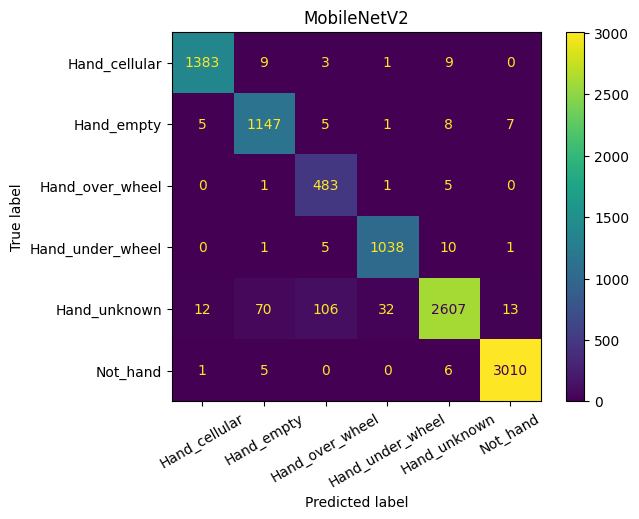

In [67]:
plot_confusion_matrix(labels, mn_preds, title='MobileNetV2')

<Figure size 2000x400 with 0 Axes>

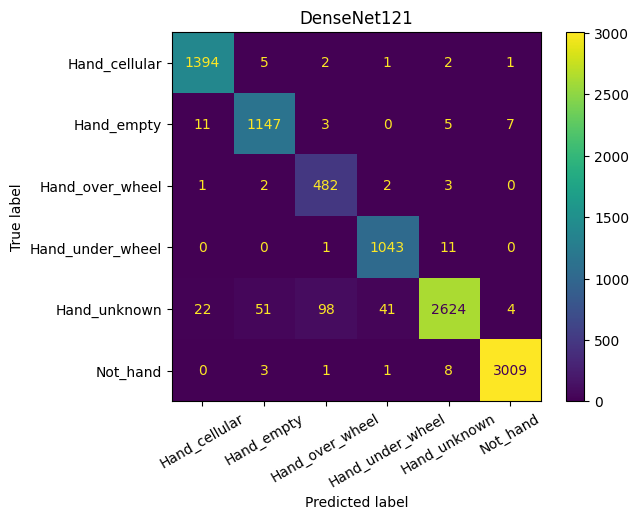

In [68]:
plot_confusion_matrix(labels, dn121_preds, title='DenseNet121')

<Figure size 2000x400 with 0 Axes>

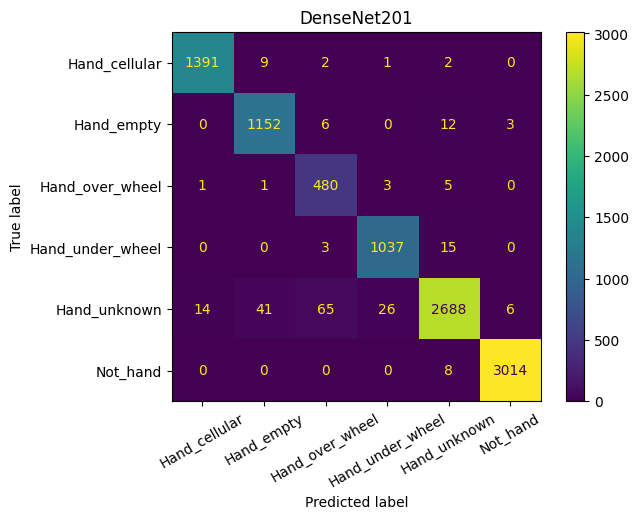

In [69]:
plot_confusion_matrix(labels, dn201_preds, title='DenseNet201')

# Рассчет среднего времени инференса моделей

In [146]:
#Функция для подсчета среднего времени обработки 1 изображения
import time

def measure_average_inference_time(model):
    test_single_loader = DataLoader(test_dataset, batch_size=1,
                                         shuffle=False)
    model.eval()
    time_sum = 0
    for data in tqdm(test_single_loader):
        start = time.time()
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
    #         print(images.shape)
        outputs = F.softmax(model(images), dim=-1)
    #         print(densenet(images).shape)
        # the class with the highest energy is what we choose as prediction
    #         print(outputs.data)
    #         break
        _, predicted = torch.max(outputs.data, dim=-1)
        end = time.time()
        time_sum += end - start
    return time_sum / len(test_single_loader)

In [147]:
#Функция для подсчета количества параметров модели
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [88]:
print('Количество параметров в MobileNet:')
count_parameters(mobilenet)

Количество параметров в MobileNet:


2231558

In [89]:
print('Количество параметров в DenseNet121:')
count_parameters(densenet)

Количество параметров в DenseNet121:


6960006

In [90]:
print('Количество параметров в DenseNet201:')
count_parameters(densenet201)

Количество параметров в DenseNet201:


18104454

In [49]:
#Среднее время обработки одного кадра MobileNetV2
measure_average_inference_time(mobilenet.to(device))

100%|██████████| 9985/9985 [03:38<00:00, 45.75it/s]


0.008532639700708595

In [50]:
#Среднее время обработки одного кадра DenseNet121
measure_average_inference_time(densenet.to(device))

100%|██████████| 9985/9985 [05:43<00:00, 29.10it/s]


0.021796631992131874

In [148]:
#Среднее время обработки одного кадра DenseNet201
measure_average_inference_time(densenet201.to(device))

100%|██████████| 9985/9985 [09:00<00:00, 18.47it/s]


0.0392126399275656